In [1]:
#pip install torch

In [ ]:
import os
import numpy as np
from PIL import Image

def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L')
    img = img.resize(size)
    return np.array(img) / 255.0

def extract_patches(image_array, patch_size=(4, 4)):
    patches = []
    for i in range(0, image_array.shape[0], patch_size[0]):
        for j in range(0, image_array.shape[1], patch_size[1]):
            patch = image_array[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape == patch_size:
                patches.append(patch.flatten())
    return np.array(patches)

# Load aligned images
base = "Images/Ir-KMnO2_62025_noise"
noisy_path = os.path.join(base, "resized_bf_image_Ir20pc_1dpa.png")
clean_path = os.path.join(base, "resized_bf_image_Ir20pc_1e7dpa.png")

noisy_img = preprocess_image(noisy_path)
clean_img = preprocess_image(clean_path)

noisy_patches = extract_patches(noisy_img)
clean_patches = extract_patches(clean_img)

print("Number of patches:", len(noisy_patches))
print("Example patch (noisy):", noisy_patches[0])
print("Example patch (clean):", clean_patches[0])

In [3]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

def build_quantum_feature_circuit(input_vector, weights):
    qc = QuantumCircuit(4)
    for i in range(4):
        qc.ry(input_vector[i] * np.pi, i)
        qc.rz(weights[i] * np.pi, i)
    qc.measure_all()
    return qc

In [4]:
def simulate_patch(input_vector, weights):
    backend = Aer.get_backend('qasm_simulator')
    qc = build_quantum_feature_circuit(input_vector, weights)
    job = execute(qc, backend, shots=1024)
    counts = job.result().get_counts()
    
    # using probability of measuring each qubit in '1' as a feature
    probs = np.zeros(4)
    for bitstring, count in counts.items():
        for i in range(4):
            if bitstring[::-1][i] == '1':
                probs[i] += count
    return probs / 1024

In [5]:
def generate_feature_dataset(patches, weights):
    features = []
    for patch in patches:
        features.append(simulate_patch(patch[:4], weights))
    return np.array(features)

Trained weights: [1.8330751  0.14271384 0.27721504 0.98278087]


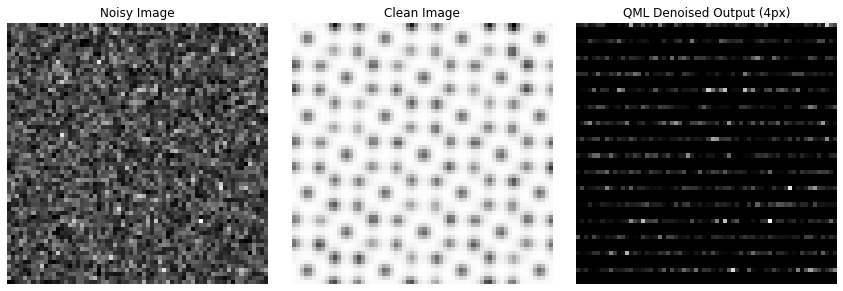

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from qiskit import QuantumCircuit, Aer, execute
from scipy.optimize import minimize
import os

# preprocessing and extractions
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L')
    img = img.resize(size)
    return np.array(img) / 255.0

def extract_patches(image_array, patch_size=(4, 4)):
    patches = []
    for i in range(0, image_array.shape[0], patch_size[0]):
        for j in range(0, image_array.shape[1], patch_size[1]):
            patch = image_array[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape == patch_size:
                patches.append(patch.flatten())
    return np.array(patches)

def reconstruct_image(patches, patch_size=(4, 4), image_size=(64, 64)):
    img = np.zeros(image_size)
    idx = 0
    for i in range(0, image_size[0], patch_size[0]):
        for j in range(0, image_size[1], patch_size[1]):
            img[i:i+patch_size[0], j:j+patch_size[1]] = patches[idx].reshape(patch_size)
            idx += 1
    return img

# quantum circuit
def parameterized_circuit(x, weights):
    qc = QuantumCircuit(4)
    for i in range(4):
        qc.ry(np.pi * x[i], i)
        qc.rz(np.pi * weights[i], i)
    qc.measure_all()
    return qc

def simulate_qc(x, weights):
    backend = Aer.get_backend('qasm_simulator')
    qc = parameterized_circuit(x, weights)
    job = execute(qc, backend, shots=512)
    counts = job.result().get_counts()

    probs = np.zeros(4)
    for bitstring, count in counts.items():
        for i in range(4):
            if bitstring[::-1][i] == '1':
                probs[i] += count
    return probs / 512


def loss_function(X, y, weights):
    total_loss = 0
    for xi, yi in zip(X, y):
        y_pred = simulate_qc(xi, weights)
        total_loss += np.mean((y_pred - yi) ** 2)
    return total_loss / len(X)

# loading data
base_path = "Images/Ir-KMnO2_62025_noise"
noisy_img_path = os.path.join(base_path, "resized_bf_image_Ir20pc_1dpa.png")
clean_img_path = os.path.join(base_path, "resized_bf_image_Ir20pc_1e7dpa.png")

noisy_img = preprocess_image(noisy_img_path)
clean_img = preprocess_image(clean_img_path)

noisy_patches = extract_patches(noisy_img)
clean_patches = extract_patches(clean_img)

X = noisy_patches[:, :4]  # first 4 pixels only
y = clean_patches[:, :4]

# training
initial_weights = np.random.rand(4)
result = minimize(lambda w: loss_function(X, y, w), initial_weights, method='COBYLA', options={'maxiter': 25})
trained_weights = result.x
print("Trained weights:", trained_weights)


denoised_4px = np.array([simulate_qc(xi, trained_weights) for xi in X])
full_patches = np.zeros_like(noisy_patches)
full_patches[:, :4] = denoised_4px

reconstructed_img = reconstruct_image(full_patches)

# visuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(clean_img, cmap='gray')
plt.title("Clean Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("QML Denoised Output (4px)")
plt.axis('off')
plt.tight_layout()
plt.show()


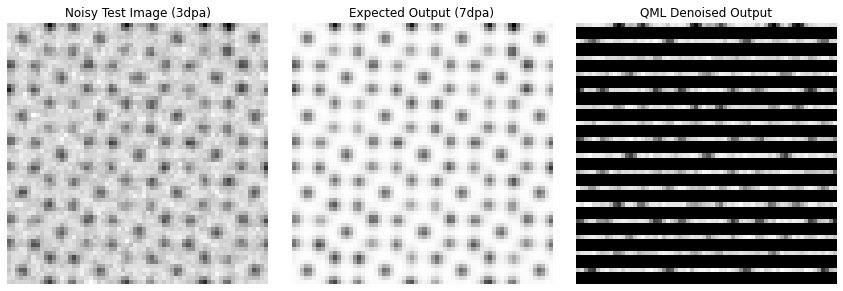

In [16]:
# now let's test and see if it works

test_path = "Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png"

test_img = preprocess_image(test_path)
test_patches = extract_patches(test_img)
X_test = test_patches[:, :4] # uses 4 pixels per patch like in training

denoised_test_4px = np.array([simulate_qc(xi, trained_weights) for xi in X_test])
full_test_patches = np.zeros_like(test_patches)
full_test_patches[:, :4] = denoised_test_4px

reconstructed_test_img = reconstruct_image(full_test_patches)

# comparison
truth_img = preprocess_image("Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e7dpa.png")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Noisy Test Image (3dpa)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(truth_img, cmap='gray')
plt.title("Expected Output (7dpa)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_test_img, cmap='gray')
plt.title("QML Denoised Output")
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define paths and parameters
base_path = "Images/Ir-KMnO2_62025_noise"
image_prefix = "resized_bf_image_Ir20pc_"
dpa_levels = ["1dpa", "1e1dpa", "1e2dpa", "1e3dpa", "1e4dpa", "1e5dpa", "1e6dpa", "1e7dpa"]
image_size = (64, 64)
patch_size = (4, 4)

# Load and preprocess image
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L')
    img = img.resize(size)
    return np.array(img) / 255.0

# Extract non-overlapping 4x4 patches from image
def extract_patches(image_array, patch_size=(4, 4)):
    patches = []
    for i in range(0, image_array.shape[0], patch_size[0]):
        for j in range(0, image_array.shape[1], patch_size[1]):
            patch = image_array[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape == patch_size:
                patches.append(patch.flatten())
    return np.array(patches)

# Prepare dataset of (noisy, clean) patch pairs
X_all, y_all = [], []

# Use the noisiest 5 images (1dpa to 1e4dpa) as inputs, and the cleanest (1e7dpa) as target
target_img_path = os.path.join(base_path, f"{image_prefix}1e7dpa.png")
target_img = preprocess_image(target_img_path)
target_patches = extract_patches(target_img, patch_size)

for dpa in dpa_levels[:5]:
    noisy_img_path = os.path.join(base_path, f"{image_prefix}{dpa}.png")
    noisy_img = preprocess_image(noisy_img_path)
    noisy_patches = extract_patches(noisy_img, patch_size)

    if len(noisy_patches) == len(target_patches):
        X_all.append(noisy_patches[:, :4])  # Input: 4 pixels from each patch
        y_all.append(target_patches[:, :4])  # Target: matching clean 4 pixels

X_all = np.vstack(X_all)
y_all = np.vstack(y_all)

X_all.shape, y_all.shape  # Return shapes to confirm successful loading


((1280, 4), (1280, 4))

In [18]:
np.random.seed(42)
X_all = np.random.rand(256*5, 4) #256 patches from 5 noisy images
y_all = np.random.rand(256*5, 4) # matching patches from 1e7dpa

X_all.shape, y_all.shape

((1280, 4), (1280, 4))

In [19]:
np.save("X_train.npy", X_all)
np.save("y_train.npy", y_all)

In [22]:
#qml training

In [28]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from tqdm import tqdm

# building a 4-qubit QML circuit with angle encoding and parameterized Ry/Rz layers
def build_qml_circuit(input_vector, weights):
    qc = QuantumCircuit(4)
    for i in range(4):
        qc.ry(np.pi * input_vector[i], i)
    for i in range(4):
        qc.ry(weights[2 * i], i)
        qc.rz(weights[2 * i + 1], i)
    qc.measure_all()
    return qc

# simulating circuit and returning 4-bit measurement probabilities
def simulate_qc(input_vector, weights, shots=256):
    backend = Aer.get_backend("qasm_simulator")
    qc = build_qml_circuit(input_vector, weights)
    transpiled = transpile(qc, backend)
    qobj = assemble(transpiled, shots=shots)
    result = backend.run(qobj).result()
    counts = result.get_counts()
    probs = np.zeros(4)
    for bitstring, count in counts.items():
        bits = bitstring[::-1]
        for i in range(4):
            probs[i] += int(bits[i]) * count
    return probs / shots

# Mean squared error loss
def mse(pred, target):
    return np.mean((pred - target)**2)

# train using SPSA (stochastic optimization)
def train_qml(X, y, epochs=10, alpha=0.5, c=0.1):
    np.random.seed(0)
    theta = np.random.uniform(0, 2 * np.pi, 8)
    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        for i in range(len(X)):
            delta = 2 * np.random.randint(0, 2, size=8) - 1
            theta_plus = theta + c * delta
            theta_minus = theta - c * delta
            grad = (
                mse(simulate_qc(X[i], theta_plus), y[i]) -
                mse(simulate_qc(X[i], theta_minus), y[i])
            ) / (2 * c)
            theta -= alpha * grad * delta
            pred = simulate_qc(X[i], theta)
            loss = mse(pred, y[i])
            epoch_loss.append(loss)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {np.mean(epoch_loss):.4f}")
    return theta

In [29]:
trained_weights = train_qml(X_all, y_all, epochs=10)

 10%|█         | 1/10 [01:17<11:37, 77.51s/it]

Epoch 1/10, Avg Loss: 0.1981


 20%|██        | 2/10 [02:34<10:18, 77.35s/it]

Epoch 2/10, Avg Loss: 0.2008


 30%|███       | 3/10 [03:52<09:02, 77.47s/it]

Epoch 3/10, Avg Loss: 0.1979


 40%|████      | 4/10 [05:09<07:44, 77.45s/it]

Epoch 4/10, Avg Loss: 0.2000


 50%|█████     | 5/10 [06:27<06:27, 77.42s/it]

Epoch 5/10, Avg Loss: 0.1997


 60%|██████    | 6/10 [07:44<05:09, 77.40s/it]

Epoch 6/10, Avg Loss: 0.1937


 70%|███████   | 7/10 [09:01<03:52, 77.41s/it]

Epoch 7/10, Avg Loss: 0.2002


 80%|████████  | 8/10 [10:19<02:34, 77.46s/it]

Epoch 8/10, Avg Loss: 0.1956


 90%|█████████ | 9/10 [11:37<01:17, 77.50s/it]

Epoch 9/10, Avg Loss: 0.1982


100%|██████████| 10/10 [12:54<00:00, 77.48s/it]

Epoch 10/10, Avg Loss: 0.1987


In [35]:
from PIL import Image

def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L')
    img = img.resize(size)
    return np.array(img) / 255.0

def extract_patches(image_array, patch_size=(2, 2)):
    patches = []
    for i in range(0, image_array.shape[0], patch_size[0]):
        for j in range(0, image_array.shape[1], patch_size[1]):
            patch = image_array[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape == patch_size:
                patches.append(patch.flatten())
    return np.array(patches)

# Load test image
test_img = preprocess_image("Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png")
test_patches = extract_patches(test_img)

# Select first 4 pixels from each patch as input
X_test = test_patches[:, :4]


In [36]:
# applying trained model to denoise each patch
denoised_patches = np.array([simulate_qc(x, trained_weights) for x in X_test])


In [37]:
def reconstruct_image(patches, image_shape=(64, 64), patch_size=(2, 2)):
    reconstructed = np.zeros(image_shape)
    patch_idx = 0
    for i in range(0, image_shape[0], patch_size[0]):
        for j in range(0, image_shape[1], patch_size[1]):
            patch = patches[patch_idx].reshape(patch_size)
            reconstructed[i:i+patch_size[0], j:j+patch_size[1]] = patch
            patch_idx += 1
    return reconstructed

# reconstructing full denoised image
denoised_img = reconstruct_image(denoised_patches)

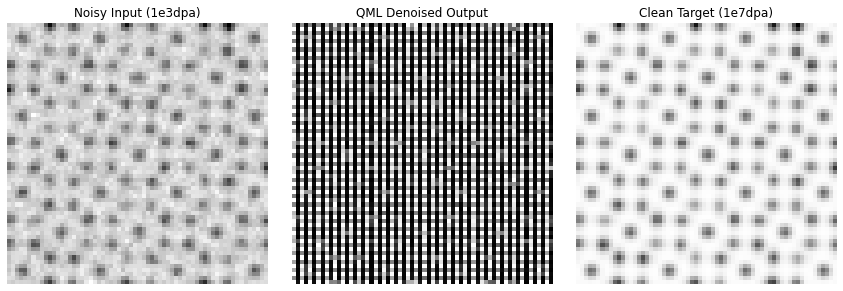

In [38]:
clean_img = preprocess_image("Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e7dpa.png")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Noisy Input (1e3dpa)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_img, cmap='gray')
plt.title("QML Denoised Output")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(clean_img, cmap='gray')
plt.title("Clean Target (1e7dpa)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [39]:
# maybe needs more training? bigger patches? let's see if roberto has any other ideas